In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model
import mlflow
import mlflow.keras

tf.random.set_seed(42)

# Creating dataset

In [2]:
folder_path = os.path.join(os.getcwd(), "Images")
folder_path

'/home/jbrichardet/Documents/workspace/machine_learning/PDeepLearning/Images'

# Image pipeline

In [3]:
input_shape=(32, 180, 180, 3)
split=0.2
train_ds = keras.preprocessing.image_dataset_from_directory(
    folder_path,
    label_mode='categorical',
    image_size=input_shape[1:3],
    validation_split=split,
    subset="training",
    seed=42
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    folder_path,
    label_mode='categorical',
    image_size=input_shape[1:3],
    validation_split=split,
    subset="validation",
    seed=42
)
class_names = train_ds.class_names
num_classes = len(class_names)

#train_ds = train_ds.prefetch(buffer_size=32)
#test_ds = test_ds.prefetch(buffer_size=32)


Found 20570 files belonging to 120 classes.
Using 16456 files for training.


2022-04-27 16:25:37.267587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 16:25:37.309078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 16:25:37.309190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 16:25:37.313989: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 20570 files belonging to 120 classes.
Using 4114 files for validation.


In [42]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #zca_whitening=True, 
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split=split,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    zoom_range=0.2,
    brightness_range=[0.3, 1]
)

datagen.fit(next(train_ds.as_numpy_iterator())[0])

train_gen = datagen.flow_from_directory(folder_path, subset="training")
val_gen = datagen.flow_from_directory(folder_path, subset="validation")


Found 16500 images belonging to 120 classes.
Found 4070 images belonging to 120 classes.


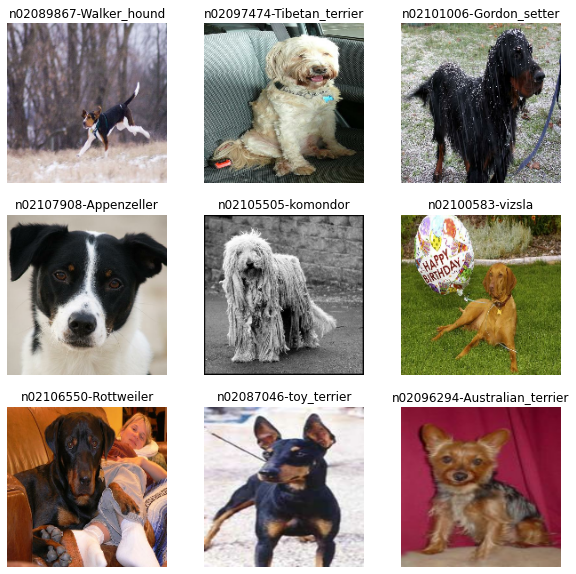

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10), facecolor='white')
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast([0.5,0]),
        layers.GaussianNoise(0.2)
    ]
)


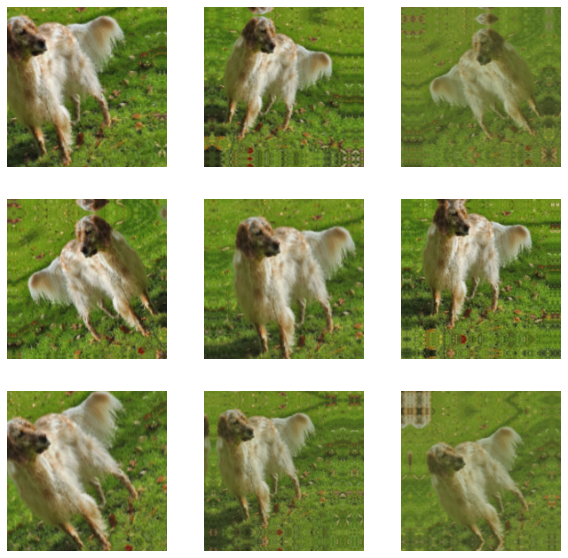

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
def plot_acc(history, title, show=True):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10), facecolor='white')
    fig.suptitle(title)
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.plot(history['val_Top5 accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation', 'val_Top5 accuracy'], loc='upper left')

    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    
    if show:
        plt.show()
    return fig

# Building the model

## Naive approach

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_56 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 conv2d_57 (Conv2D)          (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 90, 90, 32)        4640      
                                                      

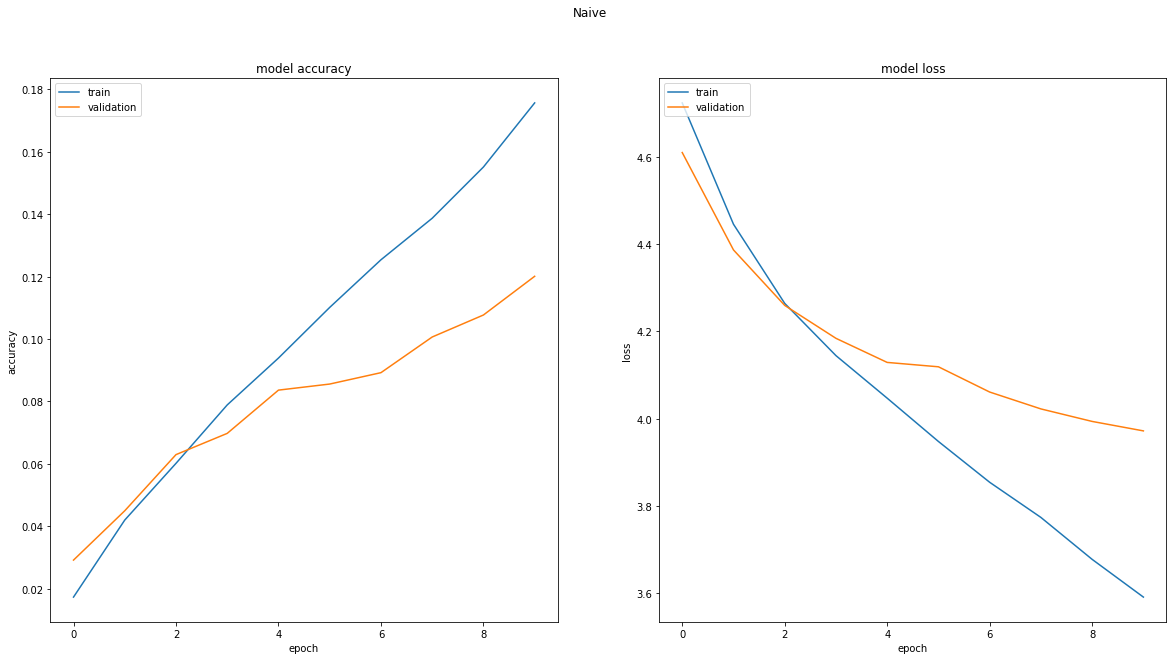

In [28]:
num_classes = len(class_names)

model = Sequential([
  layers.Input(shape=input_shape[1:]),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
epochs=10
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

plot_acc(history.history, 'Naive')

## VGG

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 128)       73856     
                                                             

2022-04-06 08:37:42.505568: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-04-06 08:37:43.560128: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


515/515 [==============================] - 39s 70ms/step - loss: 4.7461 - accuracy: 0.0152 - val_loss: 4.6290 - val_accuracy: 0.0226
Epoch 2/20
515/515 [==============================] - 35s 68ms/step - loss: 4.5475 - accuracy: 0.0285 - val_loss: 4.5129 - val_accuracy: 0.0355
Epoch 3/20
515/515 [==============================] - 35s 69ms/step - loss: 4.4399 - accuracy: 0.0388 - val_loss: 4.4099 - val_accuracy: 0.0438
Epoch 4/20
515/515 [==============================] - 35s 68ms/step - loss: 4.3049 - accuracy: 0.0546 - val_loss: 4.3034 - val_accuracy: 0.0537
Epoch 5/20
515/515 [==============================] - 35s 68ms/step - loss: 4.1854 - accuracy: 0.0688 - val_loss: 4.2479 - val_accuracy: 0.0605
Epoch 6/20
515/515 [==============================] - 35s 68ms/step - loss: 4.0918 - accuracy: 0.0814 - val_loss: 4.1996 - val_accuracy: 0.0676
Epoch 7/20
515/515 [==============================] - 35s 68ms/step - loss: 4.0064 - accuracy: 0.0924 - val_loss: 4.1304 - val_accuracy: 0.0756
Epo

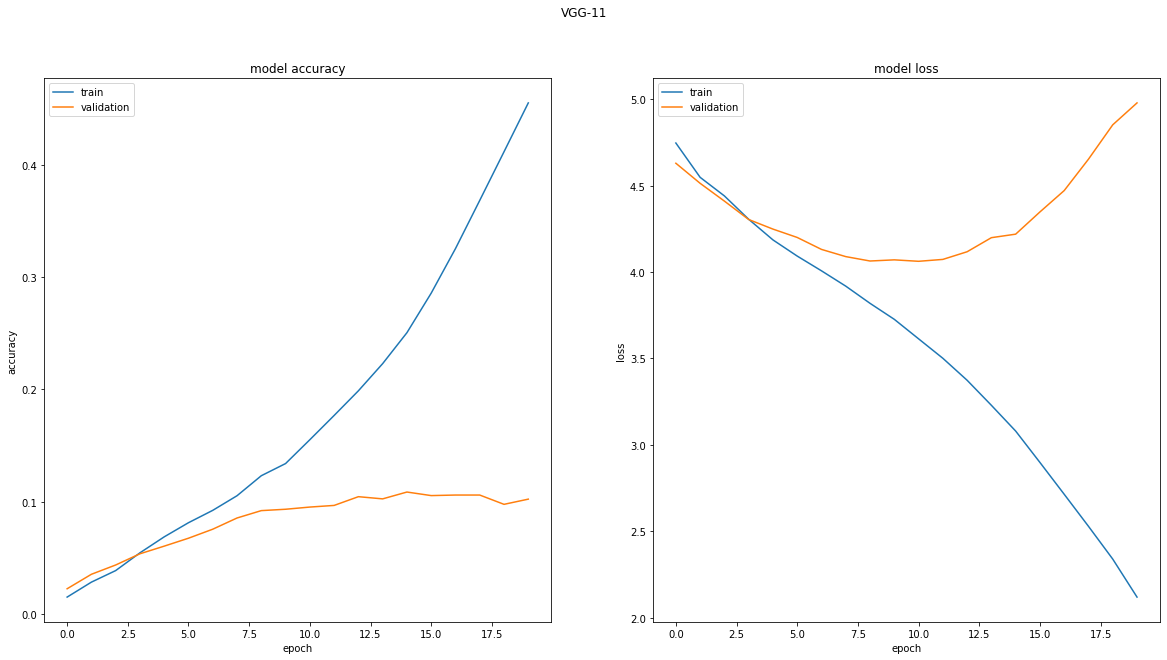

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 128)       73856     
                                                           

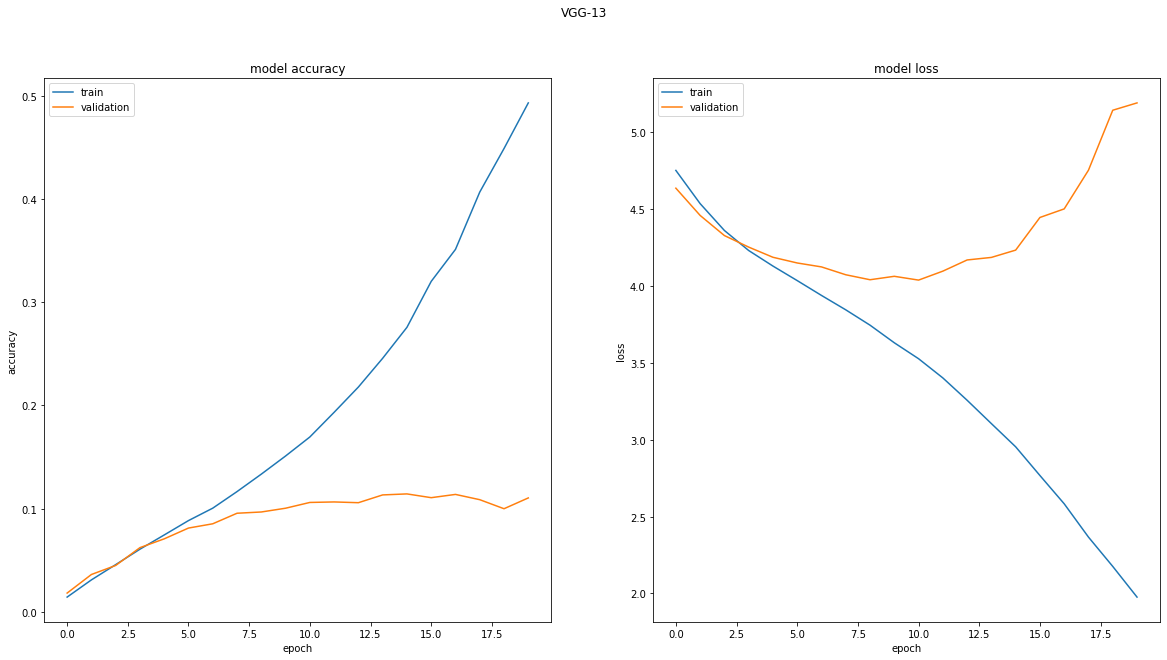

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 128)       73856     
                                                           

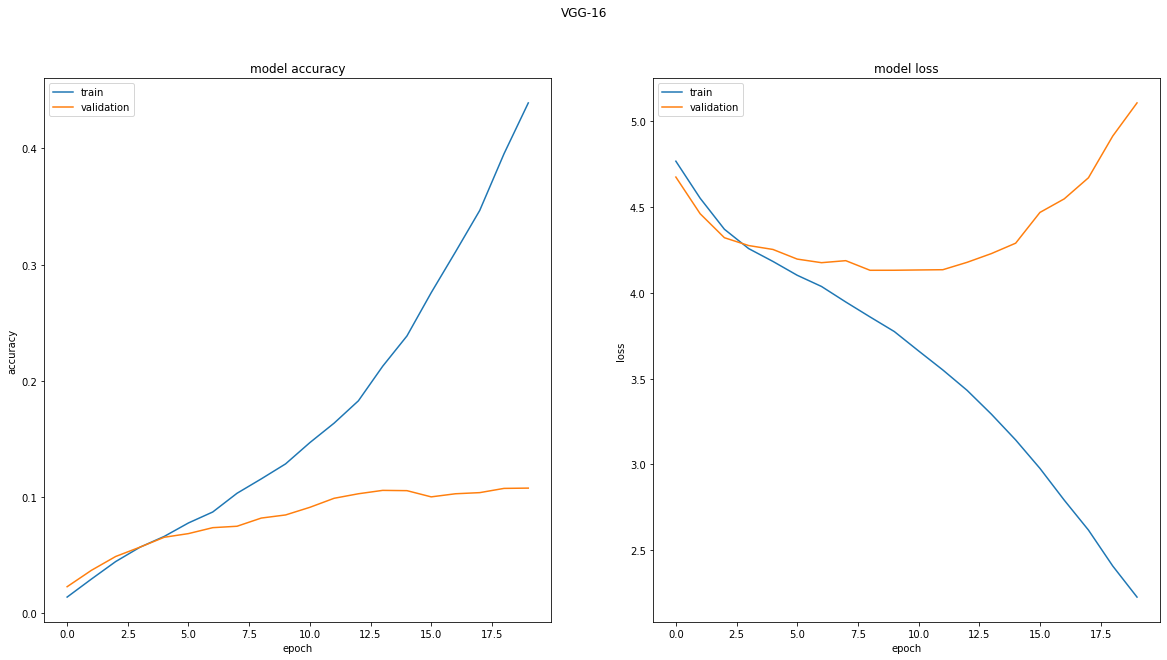

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 90, 90, 128)       73856     
                                                           

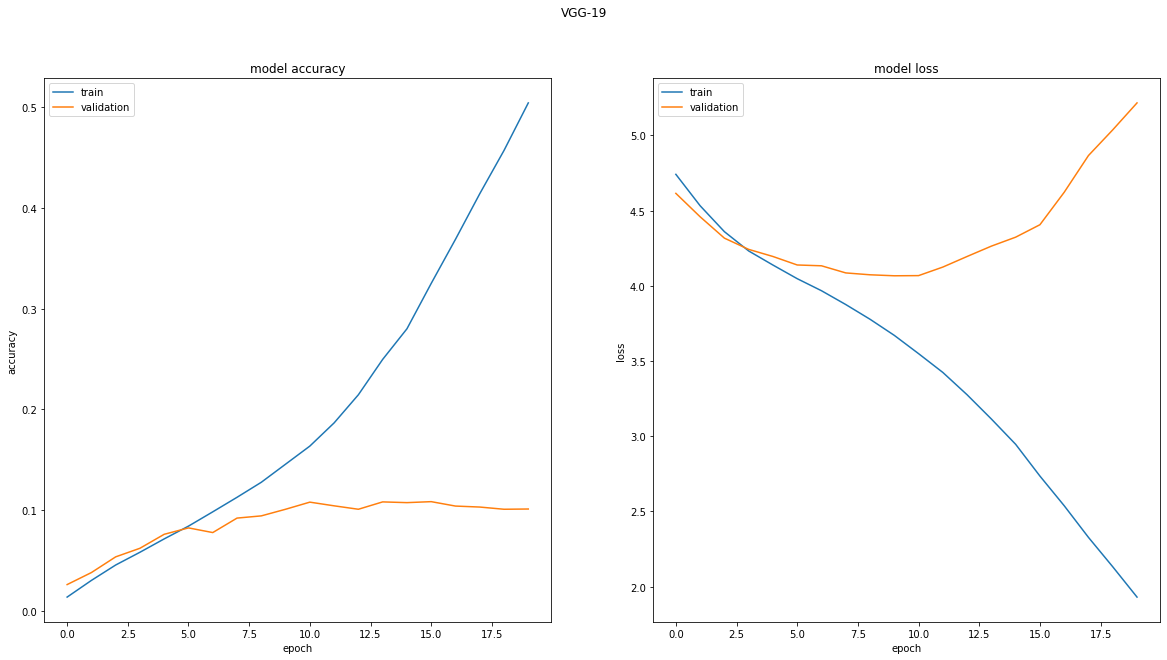

In [7]:
def make_vgg(num_layers=11):
    inputs = layers.Input(shape=input_shape[1:])
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    if num_layers >= 13:
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    if num_layers >= 13:
        x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    if num_layers >= 16:
        x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    if num_layers >= 19:
        x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    if num_layers >= 16:
        x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    if num_layers >= 19:
        x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    if num_layers >= 16:
        x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    if num_layers >= 19:
        x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dense(1000, activation='relu')(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, f'VGG-{layers}')

epochs=20
architectures = [11, 13, 16, 19]

for arch in architectures:
    tf.keras.backend.clear_session()
    model = make_vgg()
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(
      train_ds,
      validation_data=test_ds,
      epochs=epochs
    )
    plot_acc(history.history, f'VGG-{arch}')


## ResNet

Model: "ResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']         

 batch_normalization_7 (BatchNo  (None, 23, 23, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 12, 12, 512)  131584      ['add_1[0][0]']                  
                                                                                                  
 add_2 (Add)                    (None, 12, 12, 512)  0           ['max_pooling2d_2[0][0]',        
                                                                  'conv2d_4[0][0]']               
                                                                                                  
 activatio

2022-04-07 09:55:33.539420: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-04-07 09:55:34.490055: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-07 09:55:34.490296: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-07 09:55:34.490309: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-04-07 09:55:34.490506: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-07 09:55:34.490532: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-07 09:55:34.966571: I tensorflow/stream_executor/cuda/c

515/515 [==============================] - 85s 147ms/step - loss: 4.7966 - accuracy: 0.0219 - val_loss: 4.7133 - val_accuracy: 0.0236
Epoch 2/50
515/515 [==============================] - 63s 123ms/step - loss: 4.3406 - accuracy: 0.0469 - val_loss: 4.8889 - val_accuracy: 0.0462
Epoch 3/50
515/515 [==============================] - 64s 124ms/step - loss: 4.0648 - accuracy: 0.0681 - val_loss: 4.2833 - val_accuracy: 0.0554
Epoch 4/50
515/515 [==============================] - 64s 124ms/step - loss: 3.8151 - accuracy: 0.1034 - val_loss: 4.1333 - val_accuracy: 0.0839
Epoch 5/50
515/515 [==============================] - 64s 124ms/step - loss: 3.6053 - accuracy: 0.1342 - val_loss: 3.7595 - val_accuracy: 0.1291
Epoch 6/50
515/515 [==============================] - 64s 124ms/step - loss: 3.3831 - accuracy: 0.1649 - val_loss: 4.0255 - val_accuracy: 0.1026
Epoch 7/50
515/515 [==============================] - 64s 125ms/step - loss: 3.2161 - accuracy: 0.1983 - val_loss: 3.9437 - val_accuracy: 0.1

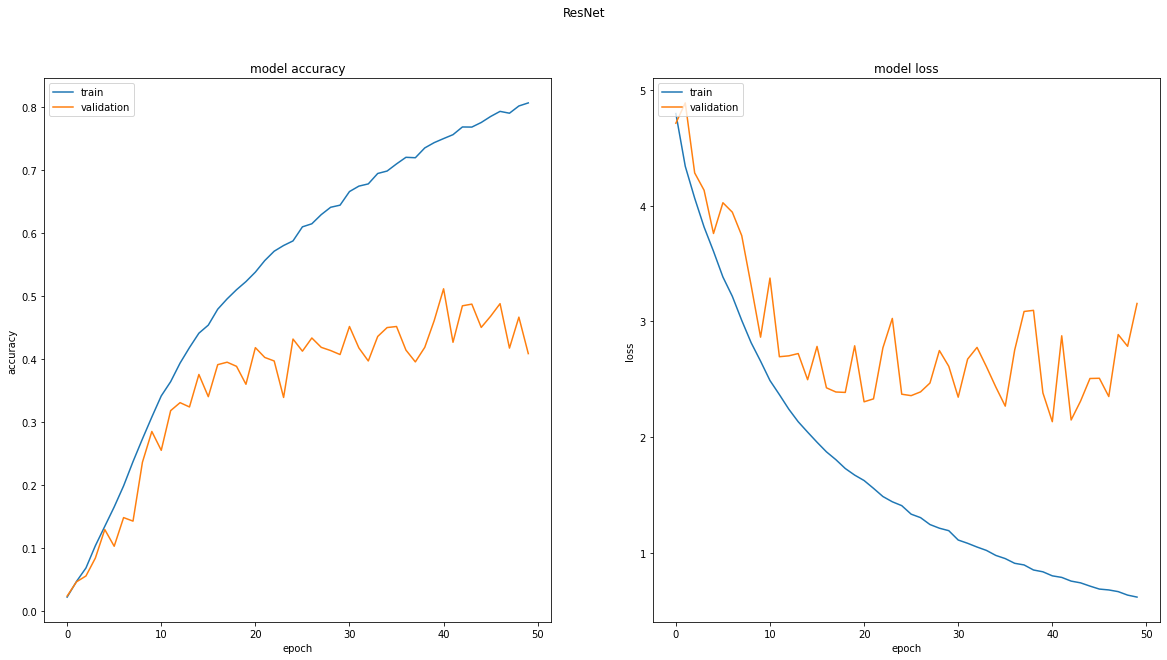

In [12]:
inputs = keras.Input(shape=input_shape[1:])
# Image augmentation block
x = data_augmentation(inputs)

# Entry block
x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

for size in [128, 256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='ResNet')
model.summary()
model.compile(optimizer=keras.optimizers.Adam(1e-3),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
epochs=50
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)
plot_acc(history.history, f'ResNet')

## Xception

In [33]:
def conv_bn(x, filters, kernel_size, strides=1):
    '''Creating Conv-BatchNorm block'''
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

def sep_bn(x, filters, kernel_size, strides=1):
    '''Creating separableConv-BatchNorm block'''
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [31]:
def entry_flow(x):
    '''entry flow'''
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    x = ReLU()(x)
    previous_block_activation = x 

    x = sep_bn(x, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)

    previous_block_activation = conv_bn(previous_block_activation, filters=128, kernel_size = 1,strides=2)
    x = Add()([previous_block_activation,x])

    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)

    previous_block_activation = conv_bn(previous_block_activation, filters=256, kernel_size = 1,strides=2)
    x = Add()([previous_block_activation,x])

    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)

    previous_block_activation = conv_bn(previous_block_activation, filters=728, kernel_size = 1,strides=2)
    x = Add()([previous_block_activation,x])
    return x

def middle_flow(tensor):
    '''Middle flow'''
    previous_block_activation = tensor
    for _ in range(8):
        x = ReLU()(previous_block_activation)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        previous_block_activation = Add()([previous_block_activation,x])
        
    return previous_block_activation

def exit_flow(tensor):
    '''Exit flow'''
    previous_block_activation = tensor
    x = ReLU()(previous_block_activation)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    previous_block_activation = conv_bn(previous_block_activation, filters =1024, kernel_size=1, strides =2)
    x = Add()([previous_block_activation,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units = num_classes, activation = 'softmax')(x)
    
    return x

In [34]:
inputs = Input(shape = input_shape[1:])
x = entry_flow(inputs)
x = middle_flow(x)
outputs = exit_flow(x)

model = Model(inputs=inputs, outputs=outputs, name='Xception')
model.summary()
model.compile(optimizer=keras.optimizers.Adam(1e-5),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)
plot_acc(history.history, 'Xception')

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 90, 90, 32)   864         ['input_26[0][0]']               
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 90, 90, 32)  128         ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                           

 conv2d_8 (Conv2D)              (None, 12, 12, 728)  186368      ['batch_normalization_11[0][0]'] 
                                                                                                  
 batch_normalization_13 (BatchN  (None, 23, 23, 728)  2912       ['separable_conv2d_5[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_14 (BatchN  (None, 12, 12, 728)  2912       ['conv2d_8[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 12, 12, 728)  0          ['batch_normalization_13[0][0]'] 
                                                                                                  
 add_14 (A

                                                                                                  
 batch_normalization_22 (BatchN  (None, 12, 12, 728)  2912       ['separable_conv2d_13[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 re_lu_17 (ReLU)                (None, 12, 12, 728)  0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 separable_conv2d_14 (Separable  (None, 12, 12, 728)  536536     ['re_lu_17[0][0]']               
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_23 (BatchN  (None, 12, 12, 728)  2912       ['separable_conv2d_14[0][0]']    
 ormalizat

 re_lu_28 (ReLU)                (None, 12, 12, 728)  0           ['batch_normalization_30[0][0]'] 
                                                                                                  
 separable_conv2d_22 (Separable  (None, 12, 12, 728)  536536     ['re_lu_28[0][0]']               
 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_31 (BatchN  (None, 12, 12, 728)  2912       ['separable_conv2d_22[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 re_lu_29 (ReLU)                (None, 12, 12, 728)  0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 separable

                                                                                                  
 batch_normalization_39 (BatchN  (None, 12, 12, 728)  2912       ['separable_conv2d_30[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 re_lu_40 (ReLU)                (None, 12, 12, 728)  0           ['batch_normalization_39[0][0]'] 
                                                                                                  
 separable_conv2d_31 (Separable  (None, 12, 12, 1024  752024     ['re_lu_40[0][0]']               
 Conv2D)                        )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 6, 6, 1024)   745472      ['add_22[0][0]']                 
          

2022-04-07 21:20:22.619649: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-07 21:20:22.619672: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-07 21:20:22.625807: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.50GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-07 21:20:22.625821: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

 11/515 [..............................] - ETA: 1:31 - loss: 4.8049 - accuracy: 0.0000e+00

KeyboardInterrupt: 

# Transfer learning

## Top level training

In [19]:
def build_top_layers(inputs, regularizer, dropout, regularizer_lr, max_norm=None):
    regularizer = regularizer(regularizer_lr) if regularizer else None
    norm = keras.constraints.max_norm(max_norm) if max_norm else None 
    #x = keras.layers.Conv2D(64, 3, activation='relu')(x)
    x = keras.layers.GlobalAveragePooling2D()(inputs)
    #x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dense(2048, activation='relu')(x)
    #x = keras.layers.Dense(2048, activation='relu')(x)
    #x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizer, kernel_constraint=norm, bias_constraint=norm)(x)
    #x = keras.layers.GaussianNoise(0.1)(x)
    #x = keras.layers.Activation(activation='relu')(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizer, kernel_constraint=norm, bias_constraint=norm)(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizer, kernel_constraint=norm, bias_constraint=norm)(x)
    x = keras.layers.Dropout(dropout)(x)
    return keras.layers.Dense(num_classes, activation='softmax')(x)

Transfering to xception
--------------------------------------------------------------------------------
Epoch 1/100
515/515 [==============================] - 24s 44ms/step - loss: 2.8246 - accuracy: 0.3474 - Top2 accuracy: 0.4886 - Top3 accuracy: 0.5699 - Top5 accuracy: 0.6565 - val_loss: 2.3404 - val_accuracy: 0.4596 - val_Top2 accuracy: 0.6021 - val_Top3 accuracy: 0.6804 - val_Top5 accuracy: 0.7647 - lr: 0.0423
Epoch 2/100
515/515 [==============================] - 22s 43ms/step - loss: 2.4216 - accuracy: 0.4488 - Top2 accuracy: 0.6005 - Top3 accuracy: 0.6765 - Top5 accuracy: 0.7539 - val_loss: 2.1560 - val_accuracy: 0.5053 - val_Top2 accuracy: 0.6582 - val_Top3 accuracy: 0.7314 - val_Top5 accuracy: 0.8017 - lr: 0.0423
Epoch 3/100
515/515 [==============================] - 22s 42ms/step - loss: 2.2974 - accuracy: 0.4863 - Top2 accuracy: 0.6327 - Top3 accuracy: 0.7058 - Top5 accuracy: 0.7785 - val_loss: 2.1717 - val_accuracy: 0.5224 - val_Top2 accuracy: 0.6529 - val_Top3 accuracy: 0

Epoch 27/100
515/515 [==============================] - 22s 43ms/step - loss: 1.5676 - accuracy: 0.6689 - Top2 accuracy: 0.7914 - Top3 accuracy: 0.8407 - Top5 accuracy: 0.8879 - val_loss: 1.8569 - val_accuracy: 0.6167 - val_Top2 accuracy: 0.7443 - val_Top3 accuracy: 0.8000 - val_Top5 accuracy: 0.8478 - lr: 0.0189
Epoch 28/100
515/515 [==============================] - 22s 43ms/step - loss: 1.5552 - accuracy: 0.6703 - Top2 accuracy: 0.7955 - Top3 accuracy: 0.8450 - Top5 accuracy: 0.8891 - val_loss: 1.8170 - val_accuracy: 0.6091 - val_Top2 accuracy: 0.7460 - val_Top3 accuracy: 0.8026 - val_Top5 accuracy: 0.8554 - lr: 0.0189
Epoch 29/100
515/515 [==============================] - 22s 43ms/step - loss: 1.5216 - accuracy: 0.6786 - Top2 accuracy: 0.8024 - Top3 accuracy: 0.8517 - Top5 accuracy: 0.8955 - val_loss: 1.8225 - val_accuracy: 0.6308 - val_Top2 accuracy: 0.7477 - val_Top3 accuracy: 0.8072 - val_Top5 accuracy: 0.8546 - lr: 0.0178
Epoch 30/100
515/515 [==============================] -

515/515 [==============================] - 22s 43ms/step - loss: 1.1320 - accuracy: 0.7611 - Top2 accuracy: 0.8689 - Top3 accuracy: 0.9089 - Top5 accuracy: 0.9406 - val_loss: 1.8265 - val_accuracy: 0.6337 - val_Top2 accuracy: 0.7494 - val_Top3 accuracy: 0.8002 - val_Top5 accuracy: 0.8542 - lr: 0.0085
Epoch 54/100
515/515 [==============================] - 22s 43ms/step - loss: 1.1461 - accuracy: 0.7576 - Top2 accuracy: 0.8663 - Top3 accuracy: 0.9060 - Top5 accuracy: 0.9398 - val_loss: 1.8275 - val_accuracy: 0.6315 - val_Top2 accuracy: 0.7552 - val_Top3 accuracy: 0.8072 - val_Top5 accuracy: 0.8568 - lr: 0.0085
Epoch 55/100
515/515 [==============================] - 22s 43ms/step - loss: 1.1102 - accuracy: 0.7687 - Top2 accuracy: 0.8749 - Top3 accuracy: 0.9138 - Top5 accuracy: 0.9423 - val_loss: 1.7852 - val_accuracy: 0.6368 - val_Top2 accuracy: 0.7586 - val_Top3 accuracy: 0.8097 - val_Top5 accuracy: 0.8585 - lr: 0.0080
Epoch 56/100
515/515 [==============================] - 22s 43ms/ste

515/515 [==============================] - 22s 43ms/step - loss: 0.9099 - accuracy: 0.8145 - Top2 accuracy: 0.9073 - Top3 accuracy: 0.9392 - Top5 accuracy: 0.9625 - val_loss: 1.7911 - val_accuracy: 0.6446 - val_Top2 accuracy: 0.7615 - val_Top3 accuracy: 0.8128 - val_Top5 accuracy: 0.8646 - lr: 0.0038
Epoch 80/100
515/515 [==============================] - 22s 43ms/step - loss: 0.9011 - accuracy: 0.8136 - Top2 accuracy: 0.9085 - Top3 accuracy: 0.9392 - Top5 accuracy: 0.9632 - val_loss: 1.7707 - val_accuracy: 0.6415 - val_Top2 accuracy: 0.7657 - val_Top3 accuracy: 0.8165 - val_Top5 accuracy: 0.8680 - lr: 0.0038
Epoch 81/100
515/515 [==============================] - 22s 43ms/step - loss: 0.9061 - accuracy: 0.8153 - Top2 accuracy: 0.9093 - Top3 accuracy: 0.9418 - Top5 accuracy: 0.9628 - val_loss: 1.8300 - val_accuracy: 0.6337 - val_Top2 accuracy: 0.7581 - val_Top3 accuracy: 0.8092 - val_Top5 accuracy: 0.8585 - lr: 0.0036
Epoch 82/100
515/515 [==============================] - 22s 43ms/ste

2022-04-27 17:15:01.963569: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp3kn0cq3k/model/data/model/assets


2022/04/27 17:15:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp3kn0cq3k/model, flavor: keras), fall back to return ['tensorflow==2.8.0', 'keras==2.8.0']. Set logging level to DEBUG to see the full traceback.


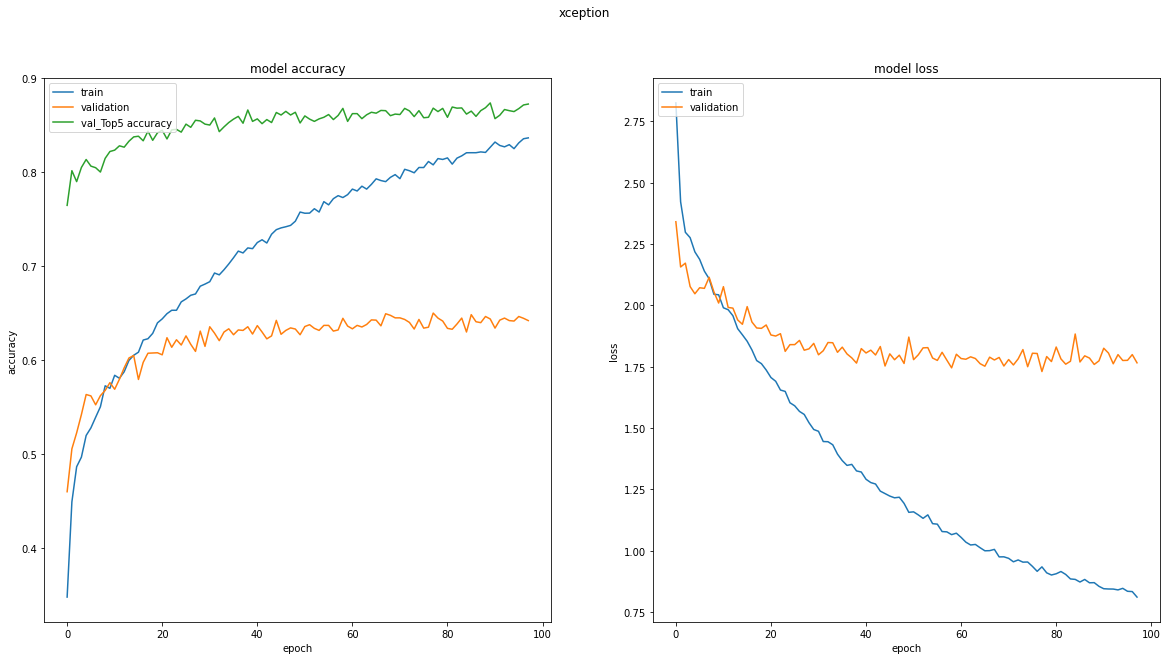

In [20]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from keras.regularizers import l1, l2, l1_l2

regularizer = [l2]
dropout_rate = [0.2]#np.arange(0.2, 0.6, 0.1)
regularizer_lr = [4e-5]#np.linspace(1e-5, 4e-5, 4)#np.logspace(-5, -3, 3)
optimizer_lr = [0.045]#np.logspace(-4, -3, 2)

base_models = [
    #('VGG-16', keras.applications.vgg16.VGG16, keras.applications.vgg16.preprocess_input),
    #('VGG-19', keras.applications.vgg19.VGG19, keras.applications.vgg19.preprocess_input),
    #('ResNetV2', keras.applications.resnet_v2.ResNet50V2, keras.applications.resnet_v2.preprocess_input),
    (keras.applications.xception.Xception, keras.applications.xception.preprocess_input),
    #(keras.applications.inception_v3.InceptionV3, keras.applications.inception_v3.preprocess_input)
]
params = []
for model, preprocess in base_models:
    for reg in regularizer:
        for drop in dropout_rate:
            for reg_lr in regularizer_lr:
                for lr in optimizer_lr:
                    params.append((reg, drop, reg_lr, lr, model, preprocess))

trained_models = []
mlflow.tensorflow.autolog()
with mlflow.start_run():
    epochs=100
    mlflow.log_param('max epochs', epochs)
    for reg, drop, reg_lr, lr, model, preprocess in params:
        with mlflow.start_run(nested=True):
            mlflow.log_param('regularizer', reg)
            mlflow.log_param('dropout', drop)
            mlflow.log_param('regularizer lr', reg_lr)

            base_model = model(
                weights='imagenet',  # Load weights pre-trained on ImageNet.
                input_shape=input_shape[1:],
                include_top=False)

            base_model.trainable = False
            
            print(f'Transfering to {base_model.name}')
            print('-'*80)

            inputs = keras.Input(shape=input_shape[1:])
            x = data_augmentation(inputs, training=True)
            x = preprocess(x)
            x = base_model(x, training=False)
            outputs = build_top_layers(x, reg, drop, reg_lr, 3)
 
            model = keras.Model(inputs=inputs, outputs=outputs, name=base_model.name)
            #model.summary()
            metrics = ['accuracy']
            for i in [2,3,5]:
                metrics.append(TopKCategoricalAccuracy(i, f'Top{i} accuracy'))
        
            model.compile(optimizer=keras.optimizers.SGD(lr, 0.9), #keras.optimizers.Adam(lr),
                          loss='categorical_crossentropy',
                          metrics=metrics)
    
            lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch,lr: lr*0.94 if epoch % 2 == 0 else lr)
            es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)
            history = model.fit(train_ds, epochs=epochs, validation_data=test_ds, callbacks=[es, lr_schedule])
            #history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=[es, lr_schedule])
            trained_models.append((base_model, model))
            
            #fig_output = os.getcwd()
            #print(f'Saving in {fig_output}')
            plot_acc(history.history,  base_model.name)
            print('=' * 80)

## Grid search for hyperparameter

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch,lr: lr*0.94 if epoch % 2 == 0 else lr)
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

def create_model(noise_amount=0.1, nodes=512, dropout=0.2, norm=3):
    regularizer = keras.regularizers.L2(4e-5)
    model = Sequential([
        keras.Input(shape=input_shape[1:]),
        data_augmentation,
        preprocess,
        base_model,
        # Top layers
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        #layers.Dropout(dropout),
        layers.Dense(nodes, kernel_regularizer=regularizer, kernel_constraint=norm, bias_constraint=norm),
        layers.GaussianNoise(noise_amount),
        layers.Activation(activation='relu'),
        layers.Dropout(dropout),
        #layers.Dense(512, activation='relu', kernel_regularizer=regularizer, kernel_constraint=norm, bias_constraint=norm),
        #layers.Dropout(dropout),
        #layers.Dense(256, activation='relu', kernel_regularizer=regularizer, kernel_constraint=norm, bias_constraint=norm),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Grid values
grid_values = {'model__noise_amount':[0.001, 0.01, 0.1, 0.2],
               'model__nodes': [512, 1024],
               'model__dropout': [0.2, 0.3],
               'model__norm': [2, 3, 4]
              }
print(grid_values)

model = KerasClassifier(
    model=create_model, 
    loss='categorical_crossentropy', 
    optimizer="adam",
    optimizer__lr=0.1,
)
print(model)

# Run GridSearch - It takes time
grid = GridSearchCV(model, param_grid = grid_values, scoring='accuracy', verbose=True)

print('Starting fitting')
grid.fit(np.fromiter(train_ds.as_numpy_iterator(), float), np.fromiter(test_ds.as_numpy_iterator(), float), fit__epoch=100)

# Plot Results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

{'model__noise_amount': [0.001, 0.01, 0.1, 0.2], 'model__nodes': [512, 1024], 'model__dropout': [0.2, 0.3], 'model__norm': [2, 3, 4]}
KerasClassifier(
	model=<function create_model at 0x7f45bc11df30>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=categorical_crossentropy
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	optimizer__lr=0.1
	class_weight=None
)
Starting fitting


## Fine tuning

2022/04/27 19:15:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2f67d349d8b1412ea997aaa236580c85', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/50
515/515 [==============================] - 93s 177ms/step - loss: 0.5801 - accuracy: 0.8976 - Top2 accuracy: 0.9338 - Top3 accuracy: 0.9567 - Top5 accuracy: 0.9736 - val_loss: 1.6359 - val_accuracy: 0.7018 - val_Top2 accuracy: 0.8126 - val_Top3 accuracy: 0.8658 - val_Top5 accuracy: 0.9037
Epoch 2/50
515/515 [==============================] - 92s 178ms/step - loss: 0.5751 - accuracy: 0.8986 - Top2 accuracy: 0.9652 - Top3 accuracy: 0.9810 - Top5 accuracy: 0.9900 - val_loss: 1.6291 - val_accuracy: 0.6915 - val_Top2 accuracy: 0.8167 - val_Top3 accuracy: 0.8583 - val_Top5 accuracy: 0.9047
Epoch 3/50
515/515 [==============================] - 92s 178ms/step - loss: 0.5640 - accuracy: 0.9030 - Top2 accuracy: 0.9657 - Top3 accuracy: 0.9815 - Top5 accuracy: 0.9897 - val_loss: 1.6092 - val_accuracy: 0.6932 - val_Top2 accuracy: 0.8109 - val_Top3 accuracy: 0.8624 - val_Top5 accuracy: 0.9054
Epoch 4/50
515/515 [==============================] - 92s 178ms/step - loss: 0.5561 - accuracy: 0

515/515 [==============================] - 92s 179ms/step - loss: 0.4221 - accuracy: 0.9487 - Top2 accuracy: 0.9852 - Top3 accuracy: 0.9928 - Top5 accuracy: 0.9963 - val_loss: 1.7732 - val_accuracy: 0.7069 - val_Top2 accuracy: 0.8177 - val_Top3 accuracy: 0.8653 - val_Top5 accuracy: 0.9011
Epoch 28/50
515/515 [==============================] - 92s 178ms/step - loss: 0.4293 - accuracy: 0.9441 - Top2 accuracy: 0.9827 - Top3 accuracy: 0.9920 - Top5 accuracy: 0.9964 - val_loss: 1.7569 - val_accuracy: 0.7081 - val_Top2 accuracy: 0.8206 - val_Top3 accuracy: 0.8675 - val_Top5 accuracy: 0.9069
Epoch 29/50
515/515 [==============================] - 92s 179ms/step - loss: 0.4291 - accuracy: 0.9442 - Top2 accuracy: 0.9837 - Top3 accuracy: 0.9913 - Top5 accuracy: 0.9959 - val_loss: 1.7188 - val_accuracy: 0.7054 - val_Top2 accuracy: 0.8255 - val_Top3 accuracy: 0.8670 - val_Top5 accuracy: 0.9054
Epoch 30/50
515/515 [==============================] - 92s 178ms/step - loss: 0.4208 - accuracy: 0.9468 - 

2022/04/27 20:32:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpheor4_8d/model, flavor: keras), fall back to return ['tensorflow==2.8.0', 'keras==2.8.0']. Set logging level to DEBUG to see the full traceback.


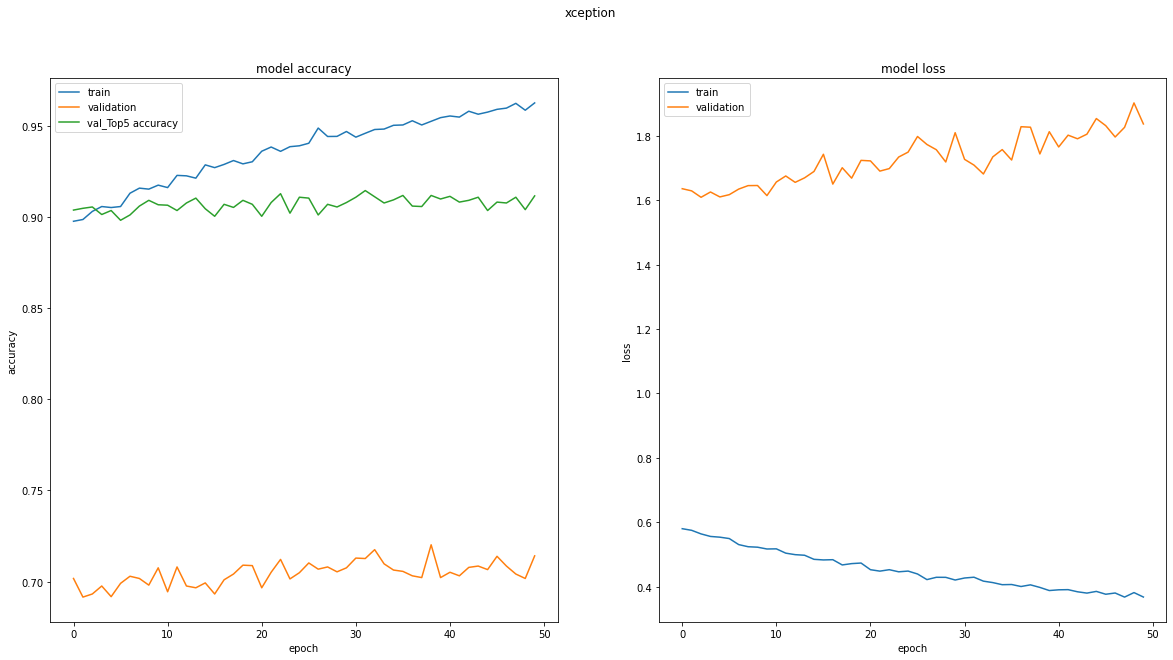

In [24]:
for base_model, model in trained_models:
    base_model.trainable = True
    #model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
        loss='categorical_crossentropy',
        metrics=metrics,
    )

    epochs = 50
    history = model.fit(train_ds, epochs=epochs, validation_data=test_ds)#, callbacks=[es])
    plot_acc(history.history, model.name)

In [25]:
for _, model in trained_models:
    model.save(os.path.join(os.getcwd(), f'Best {model.name}'))

INFO:tensorflow:Assets written to: /home/jbrichardet/Documents/workspace/machine_learning/PDeepLearning/Best xception/assets


Epoch 1/20


2022-04-21 10:31:36.444230: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-04-21 10:31:37.388121: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-21 10:31:37.388295: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-21 10:31:37.388308: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-04-21 10:31:37.388488: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-21 10:31:37.388513: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-21 10:31:37.762161: W tensorflow/core/common_runtime/bf

515/515 [==============================] - 112s 196ms/step - loss: 1.1313 - accuracy: 0.6895 - top_k_categorical_accuracy: 0.9081 - val_loss: 1.5212 - val_accuracy: 0.6169 - val_top_k_categorical_accuracy: 0.8636
Epoch 2/20
515/515 [==============================] - 96s 186ms/step - loss: 1.0968 - accuracy: 0.6941 - top_k_categorical_accuracy: 0.9174 - val_loss: 1.4855 - val_accuracy: 0.6303 - val_top_k_categorical_accuracy: 0.8627
Epoch 3/20
515/515 [==============================] - 94s 183ms/step - loss: 1.0105 - accuracy: 0.7148 - top_k_categorical_accuracy: 0.9265 - val_loss: 1.4241 - val_accuracy: 0.6393 - val_top_k_categorical_accuracy: 0.8792
Epoch 4/20
515/515 [==============================] - 94s 183ms/step - loss: 0.9077 - accuracy: 0.7423 - top_k_categorical_accuracy: 0.9375 - val_loss: 1.3938 - val_accuracy: 0.6546 - val_top_k_categorical_accuracy: 0.8814
Epoch 5/20
515/515 [==============================] - 96s 187ms/step - loss: 0.8838 - accuracy: 0.7487 - top_k_categor

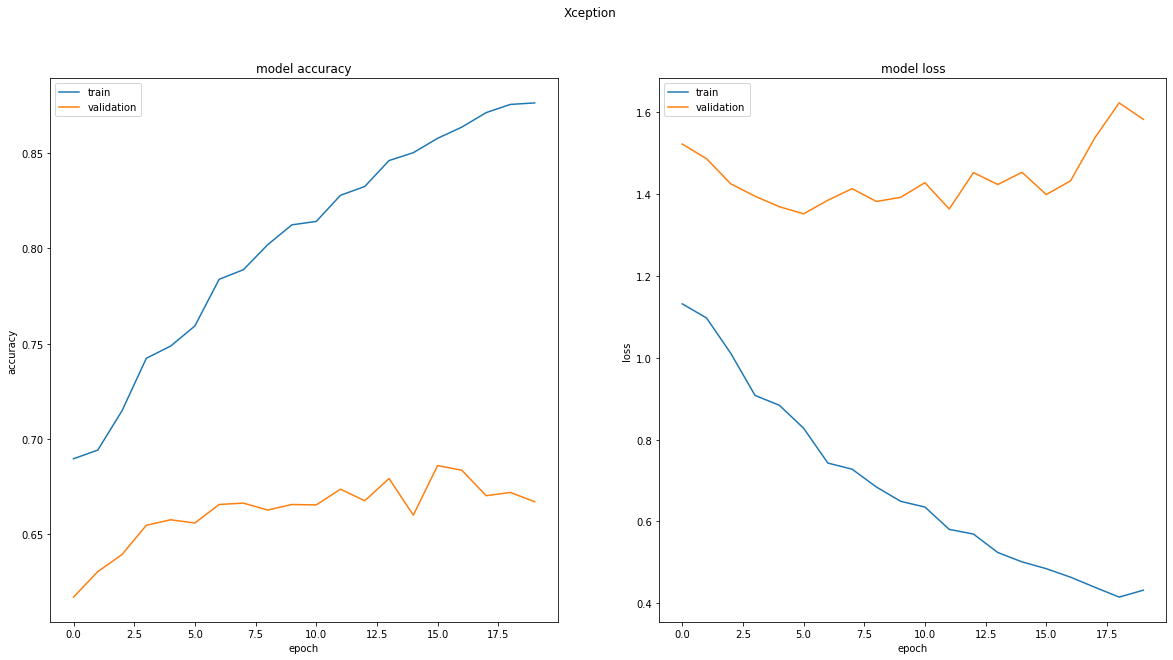

In [7]:
loaded = keras.models.load_model(os.path.join(os.getcwd(), 'Xception'))
loaded.trainable = True
metrics = ['accuracy', 'top_k_categorical_accuracy']
loaded.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=metrics,
)

epochs = 20
history = loaded.fit(train_ds, epochs=epochs, validation_data=test_ds)
plot_acc(history.history, loaded.name)

# Test

In [ ]:
img = keras.preprocessing.image.load_img(
    "jerome.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)

top4 = predictions.argsort()[0, -1:-5:-1]

for race, acc in zip(np.array(race_names)[top4], predictions[0, top4]):
    print(f'{race} at {acc:.2%}')